# Analisis Segmentasi Pelanggan (RFM Analysis) 🛒
**Oleh: Wisma Jaya Laksana**

Notebook ini berisi langkah-langkah *End-to-End* Data Analysis menggunakan metode **RFM (Recency, Frequency, Monetary)** untuk mengelompokkan pelanggan berdasarkan perilaku belanja mereka. 

Tujuan analisis ini adalah untuk menjawab pertanyaan bisnis: *"Siapa pelanggan paling berharga kita, dan siapa yang hampir pergi meninggalkan toko kita?"*

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

# Baca data CSV
df = pd.read_csv('../data/Online Retail.csv')

# Cek isinya
print("✅ Data berhasil dimuat!")
display(df.head())

✅ Data berhasil dimuat!


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


## 1. Data Cleaning & Preparation
Data mentah dari sistem kasir/retail seringkali memiliki *missing values* atau anomali. Sebelum dianalisis, data harus dibersihkan dengan langkah:
1. **Hapus Missing ID:** Menghapus transaksi yang tidak memiliki `CustomerID` (karena RFM butuh identitas pelanggan).
2. **Hapus Retur/Error:** Menghapus transaksi dengan `Quantity` atau `UnitPrice` bernilai negatif (biasanya merupakan retur barang atau pesanan batal).
3. **Feature Engineering:** Membuat kolom baru `TotalPrice` (Quantity dikali UnitPrice) sebagai total nilai omzet transaksi.

In [2]:
# --- TAHAP 1: CHECKING DATA ---
print("Info Data Awal:")
df.info()

# --- TAHAP 2: CLEANING ---
# 1. Hapus baris yang tidak ada CustomerID-nya
# (Logika: Kita gak bisa analisa RFM kalau gak tau siapa pelanggannya)
df = df.dropna(subset=['CustomerID'])

# 2. Hapus transaksi "batal" atau error (Quantity negatif)
# (Di data retail, quantity minus biasanya artinya barang direturn/batal)
df = df[df['Quantity'] > 0]
df = df[df['UnitPrice'] > 0]

# --- TAHAP 3: FORMATTING ---
# 1. Ganti CustomerID jadi integer (biar gak ada koma .0 dibelakang)
df['CustomerID'] = df['CustomerID'].astype(int)

# 2. Ubah InvoiceDate jadi tipe 'datetime' (supaya bisa dihitung selisih harinya nanti)
# Format tanggal di data kamu sepertinya: "bulan/tanggal/tahun jam:menit"
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# 3. Bikin kolom baru 'TotalPrice' (PENTING!)
# Ini pengganti 'tran_amount' di kodingan Nabila
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Cek hasil akhirnya
print("\n✅ Data setelah dibersihkan:")
df.info()
display(df.head())

Info Data Awal:
<class 'pandas.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  str    
 1   StockCode    541909 non-null  str    
 2   Description  540455 non-null  str    
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  str    
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  str    
dtypes: float64(2), int64(1), str(5)
memory usage: 33.1 MB

✅ Data setelah dibersihkan:
<class 'pandas.DataFrame'>
Index: 397884 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397884 non-null  str           
 1   StockCode    397884 non-null  str           
 2   Description  397884 non-null  str           
 3   Quantity     39788

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


## 2. Menghitung Metrik RFM
Sekarang kita akan merangkum ratusan ribu baris data transaksi tersebut menjadi **satu baris per pelanggan**, dengan 3 metrik utama:
- **Recency (R):** Berapa hari sejak pelanggan tersebut terakhir kali berbelanja? (Makin kecil angkanya, makin bagus).
- **Frequency (F):** Berapa kali total pelanggan tersebut melakukan transaksi?
- **Monetary (M):** Berapa total uang yang dihabiskan pelanggan tersebut di toko kita?

In [3]:
import datetime as dt

# 1. Tentukan "Hari Ini" (Anggap kita analisa data   ini besoknya setelah transaksi terakhir tercatat)
current_date = df['InvoiceDate'].max() + dt.timedelta(days=1)
print(f"Tanggal referensi analisa: {current_date}")

# 2. HITUNG RFM (Group by CustomerID)
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (current_date - x.max()).days, # Recency (Hari ini - Tanggal Belanja Terakhir)
    'InvoiceNo': 'count',   # Frequency (Hitung jumlah transaksi)
    'TotalPrice': 'sum'     # Monetary (Total belanja)
}).reset_index()

# 3. Ganti nama kolom biar sesuai standar internasional
rfm.rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalPrice': 'Monetary'
}, inplace=True)

# Cek hasilnya
print("\n✅ Rapor RFM Pelanggan Berhasil Dibuat!")
display(rfm.head())

Tanggal referensi analisa: 2011-12-10 12:50:00

✅ Rapor RFM Pelanggan Berhasil Dibuat!


,CustomerID,Recency,Frequency,Monetary
0,12346,326,1,77183.60
1,12347,2,182,4310.00
2,12348,75,31,1797.24
3,12349,19,73,1757.55
4,12350,310,17,334.40


## 3. RFM Scoring & Segmentasi Pelanggan
Angka mentah RFM sulit untuk diinterpretasikan secara langsung. Oleh karena itu, kita mengubahnya menjadi skor skala 1 sampai 5 (menggunakan sistem kuantil).
- Skor **5** adalah nilai terbaik (Sangat Baru, Sangat Sering, Sangat Konsumtif).
- Skor **1** adalah nilai terburuk.

Setelah mendapat skor gabungan (misal: "555" atau "122"), kita memetakan skor tersebut ke dalam nama segmen yang mudah dipahami oleh tim Bisnis & Marketing (seperti *Champions*, *Loyal Customers*, atau *Hibernating*).

In [4]:
# --- MEMBERI SKOR 1-5 ---

# 1. Recency (Makin kecil angkanya, makin bagus skornya -> labels dibalik [5,4,3,2,1])
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5, 4, 3, 2, 1])

# 2. Frequency (Makin besar angkanya, makin bagus -> labels normal [1,2,3,4,5])
# Kita pakai .rank(method='first') karena banyak customer yang frekuensinya sama (misal sama-sama beli 1x)
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5])

# 3. Monetary (Makin besar uangnya, makin bagus -> labels normal [1,2,3,4,5])
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 5, labels=[1, 2, 3, 4, 5])

# 4. GABUNGKAN SKOR (Contoh: "555" berarti sempurna)
# Kita jadikan string biar mudah dibaca "Lima-Lima-Lima"
rfm['RFM_Score'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)

print("✅ Rapor Selesai! Lihat kolom RFM_Score:")
display(rfm.head())

✅ Rapor Selesai! Lihat kolom RFM_Score:


,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score
0,12346,326,1,77183.60,1,1,5,115
1,12347,2,182,4310.00,5,5,5,555
2,12348,75,31,1797.24,2,3,4,234
3,12349,19,73,1757.55,4,4,4,444
4,12350,310,17,334.40,1,2,2,122


In [5]:
# --- STEP 5: SEGMENTASI PELANGGAN ---

# Kita buat peta (Map) regex untuk menerjemahkan skor R dan F
# (Monetary biasanya sejalan dengan Frequency, jadi kita fokus ke R dan F dulu biar simpel)

seg_map = {
    r'[1-2][1-2]': 'Hibernating',           # R rendah, F rendah (Tidur panjang)
    r'[1-2][3-4]': 'At Risk',               # R rendah, F tinggi (Berisiko kabur)
    r'[1-2]5': 'Can\'t Lose',               # R rendah, F sangat tinggi (Mantan Sultan)
    r'3[1-2]': 'About To Sleep',            # R sedang, F rendah (Ngantuk)
    r'33': 'Need Attention',                # R sedang, F sedang (Butuh perhatian)
    r'[3-4][4-5]': 'Loyal Customers',       # R lumayan, F tinggi (Setia)
    r'41': 'Promising',                     # R tinggi, F rendah (Menjanjikan)
    r'51': 'New Customers',                 # R sangat tinggi, F rendah (Pelanggan Baru)
    r'[4-5][2-3]': 'Potential Loyalists',   # R tinggi, F lumayan (Calon setia)
    r'5[4-5]': 'Champions'                  # R sangat tinggi, F sangat tinggi (JUARA/SULTAN)
}

# Gabungkan skor R dan F saja
rfm['Segment_Map'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str)

# Ganti angka jadi nama pakai peta di atas
rfm['Segment'] = rfm['Segment_Map'].replace(seg_map, regex=True)

# Tampilkan hasilnya
print("✅ Segmentasi Selesai! Lihat kolom 'Segment':")
display(rfm[['CustomerID', 'RFM_Score', 'Segment']].head(10))

✅ Segmentasi Selesai! Lihat kolom 'Segment':


,CustomerID,RFM_Score,Segment
0,12346,115,Hibernating
1,12347,555,Champions
2,12348,234,At Risk
3,12349,444,Loyal Customers
4,12350,122,Hibernating
5,12352,345,Loyal Customers
6,12353,111,Hibernating
7,12354,134,At Risk
8,12355,112,Hibernating
9,12356,445,Loyal Customers


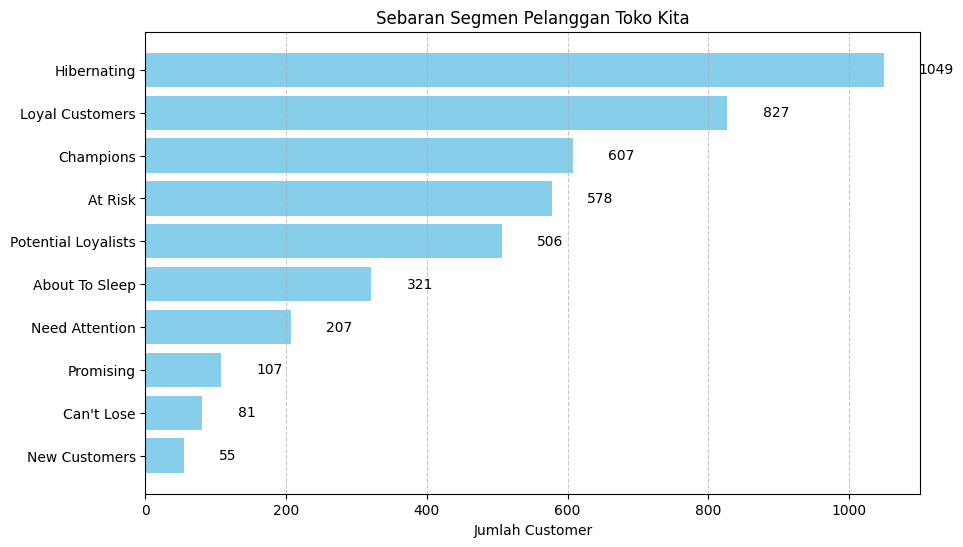

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Hitung jumlah user per segment
segment_counts = rfm['Segment'].value_counts().sort_values(ascending=True)

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.barh(segment_counts.index, segment_counts.values, color='skyblue')

# Hiasan
plt.xlabel('Jumlah Customer')
plt.title('Sebaran Segmen Pelanggan Toko Kita')
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Tambah angka di ujung batang
for bar in bars:
    plt.text(bar.get_width() + 50, bar.get_y() + bar.get_height()/2, 
             str(int(bar.get_width())), va='center')

plt.show()

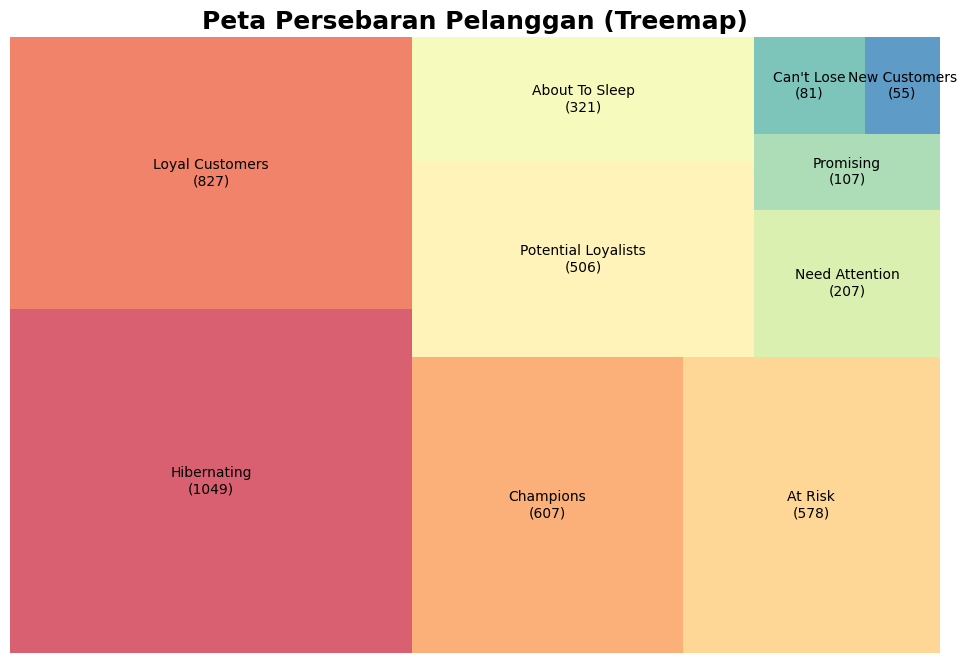

In [7]:
import squarify
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Siapkan data (Urutkan dari yang terbanyak)
segment_counts = rfm['Segment'].value_counts().sort_values(ascending=False)

# 2. Siapkan label (Nama segmen + Jumlah orangnya)
# Contoh label: "Hibernating (1049)"
labels = [f"{seg}\n({count})" for seg, count in zip(segment_counts.index, segment_counts.values)]

# 3. Bikin Plot Treemap
plt.figure(figsize=(12, 8))
squarify.plot(sizes=segment_counts.values, label=labels, 
              color=sns.color_palette("Spectral", len(segment_counts)), alpha=0.8)

# 4. Hiasan
plt.title('Peta Persebaran Pelanggan (Treemap)', fontsize=18, fontweight='bold')
plt.axis('off') # Hilangkan sumbu X dan Y biar bersih
plt.show()

In [8]:
# --- STEP TERAKHIR: SIMPAN DATA MATANG ---

# Tentukan nama file output
output_path = '../data/Hasil_Analisa_RFM_Final.csv'

# Simpan dataframe 'rfm' ke file CSV
# index=False artinya kita gak perlu menyimpan nomor baris (0,1,2...) ke dalam file
rfm.to_csv(output_path, index=False)

print(f"✅ SUKSES BESAR! Data hasil analisismu sudah aman tersimpan di:")
print(f"📂 {output_path}")
print("\nSekarang kamu siap lanjut ke tahap pembuatan Dashboard Tableau!")

✅ SUKSES BESAR! Data hasil analisismu sudah aman tersimpan di:
📂 ../data/Hasil_Analisa_RFM_Final.csv

Sekarang kamu siap lanjut ke tahap pembuatan Dashboard Tableau!


## 4. Kesimpulan & Business Insight
Berdasarkan pengolahan data di atas (yang divisualisasikan lebih mendalam menggunakan Tableau), kita dapat menarik *insight* penting berikut:

1. **Mayoritas Pelanggan Berada di Segmen "Hibernating":** Sebagian besar basis pelanggan kita adalah orang-orang yang dulu pernah beli, namun sudah lama sekali tidak kembali.
2. **Hukum Pareto Berlaku (The Power of Champions):** Meskipun pelanggan berstatus **"Champions"** dan **"Loyal Customers"** jumlah orangnya jauh lebih sedikit, namun kedua segmen inilah yang **menyumbang mayoritas total omzet (Revenue)** bagi perusahaan.

**💡 Rekomendasi Actionable:**
- **Pertahankan yang Setia:** Fokuskan budget *loyalty program*, layanan VIP, atau diskon eksklusif untuk memanjakan segmen *Champions* agar mereka tidak direbut kompetitor.
- **Reaktivasi Pelanggan Tidur:** Kirimkan *email marketing* atau promo *win-back* (diskon besar bersyarat) khusus untuk sebagian pelanggan *Hibernating* yang berpotensi aktif kembali.

---
*Data Exported to `Hasil_Analisa_RFM_Final.csv` for Tableau Dashboarding.*